# Using Opik with Langchain
Updated by: **Wilfredo Aaron Sosa Ramos**

For this guide, we will be performing a text to sql query generation task using LangChain. We will be using the Chinook database which contains the SQLite database of a music store with both employee, customer and invoice data.

We will highlight three different parts of the workflow:

1. Creating a synthetic dataset of questions
2. Creating a LangChain chain to generate SQL queries
3. Automating the evaluation of the SQL queries on the synthetic dataset

## Creating an account on Comet.com

[Comet](https://www.comet.com/site?from=llm&utm_source=opik&utm_medium=colab&utm_content=langchain&utm_campaign=opik) provides a hosted version of the Opik platform, [simply create an account](https://www.comet.com/signup?from=llm&utm_source=opik&utm_medium=colab&utm_content=langchain&utm_campaign=opik) and grab you API Key.

> You can also run the Opik platform locally, see the [installation guide](https://www.comet.com/docs/opik/self-host/overview/?from=llm&utm_source=opik&utm_medium=colab&utm_content=langchain&utm_campaign=opik) for more information.

In [1]:
%pip install --upgrade --quiet opik langchain langchain-community langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.2 MB/s eta 0:00:00


In [2]:
import opik

opik.configure(use_local=False)

OPIK: Your Opik API key is available in your account settings, can be found at https://www.comet.com/api/my/settings/ for Opik cloud


Please enter your Opik API key:··········
Do you want to use "aaronsosaramos" workspace? (Y/n)Y


OPIK: Configuration saved to file: /root/.opik.config


## Preparing our environment

First, we will download the Chinook database and set up our different API keys.

In [3]:
import os
import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [4]:
# Download the relevant data
import os
from langchain_community.utilities import SQLDatabase

import requests
import os

url = "https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite"
filename = "./data/chinook/Chinook_Sqlite.sqlite"

folder = os.path.dirname(filename)

if not os.path.exists(folder):
    os.makedirs(folder)

if not os.path.exists(filename):
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)
    print("Chinook database downloaded")

db = SQLDatabase.from_uri(f"sqlite:///{filename}")

Chinook database downloaded


## Creating a synthetic dataset

In order to create our synthetic dataset, we will be using the OpenAI API to generate 20 different questions that a user might ask based on the Chinook database.

In order to ensure that the OpenAI API calls are being tracked, we will be using the `track_openai` function from the `opik` library.

In [5]:
from opik.integrations.openai import track_openai
from openai import OpenAI
import json

os.environ["OPIK_PROJECT_NAME"] = "Demo Project"
client = OpenAI()

openai_client = track_openai(client)

prompt = """
Create 20 different example questions a user might ask based on the Chinook Database.

These questions should be complex and require the model to think. They should include complex joins and window functions to answer.

Return the response as a json object with a "result" key and an array of strings with the question.
"""

completion = openai_client.chat.completions.create(
    model="gpt-4o-mini", messages=[{"role": "user", "content": prompt}]
)

print(completion.choices[0].message.content)

OPIK: Started logging traces to the "Demo Project" project at https://www.comet.com/opik/aaronsosaramos/redirect/projects?name=Demo%20Project.


```json
{
  "result": [
    "What is the total sales amount for each customer in the last 12 months, ranked by the highest total sales for customers with more than 5 orders?",
    "Which products have an average rental duration exceeding the median rental duration for all products, and what are their corresponding rental counts?",
    "Can you provide a breakdown of the top 5 employees by total sales in each store, including the store name and employee email?",
    "List the top 3 genres that have the highest average ratings, along with the count of films for each genre, and include only those genres with at least 10 films released.",
    "What are the average payment amounts for invoices grouped by customer category and sorted by the average amount in descending order, including only categories with more than 3 customers?",
    "Which customers have spent more than the average total sales of all customers, and what are their purchase frequencies and the corresponding stores they purch

Now that we have our synthetic dataset, we can create a dataset in Comet and insert the questions into it.

Since the insert methods in the SDK deduplicates items, we can insert 20 items and if the items already exist, Opik will automatically remove them.

In [20]:
cleaned_content = completion.choices[0].message.content.strip("```json").strip("").strip(" ")
print(cleaned_content)


{
  "result": [
    "What is the total sales amount for each customer in the last 12 months, ranked by the highest total sales for customers with more than 5 orders?",
    "Which products have an average rental duration exceeding the median rental duration for all products, and what are their corresponding rental counts?",
    "Can you provide a breakdown of the top 5 employees by total sales in each store, including the store name and employee email?",
    "List the top 3 genres that have the highest average ratings, along with the count of films for each genre, and include only those genres with at least 10 films released.",
    "What are the average payment amounts for invoices grouped by customer category and sorted by the average amount in descending order, including only categories with more than 3 customers?",
    "Which customers have spent more than the average total sales of all customers, and what are their purchase frequencies and the corresponding stores they purchased fr

In [22]:
# Create the synthetic dataset
import opik

synthetic_questions = json.loads(cleaned_content)["result"]

client = opik.Opik()

dataset = client.get_or_create_dataset(name="synthetic_questions")
dataset.insert([{"question": question} for question in synthetic_questions])

OPIK: Created a "synthetic_questions" dataset at https://www.comet.com/opik/aaronsosaramos/redirect/datasets?name=synthetic_questions.


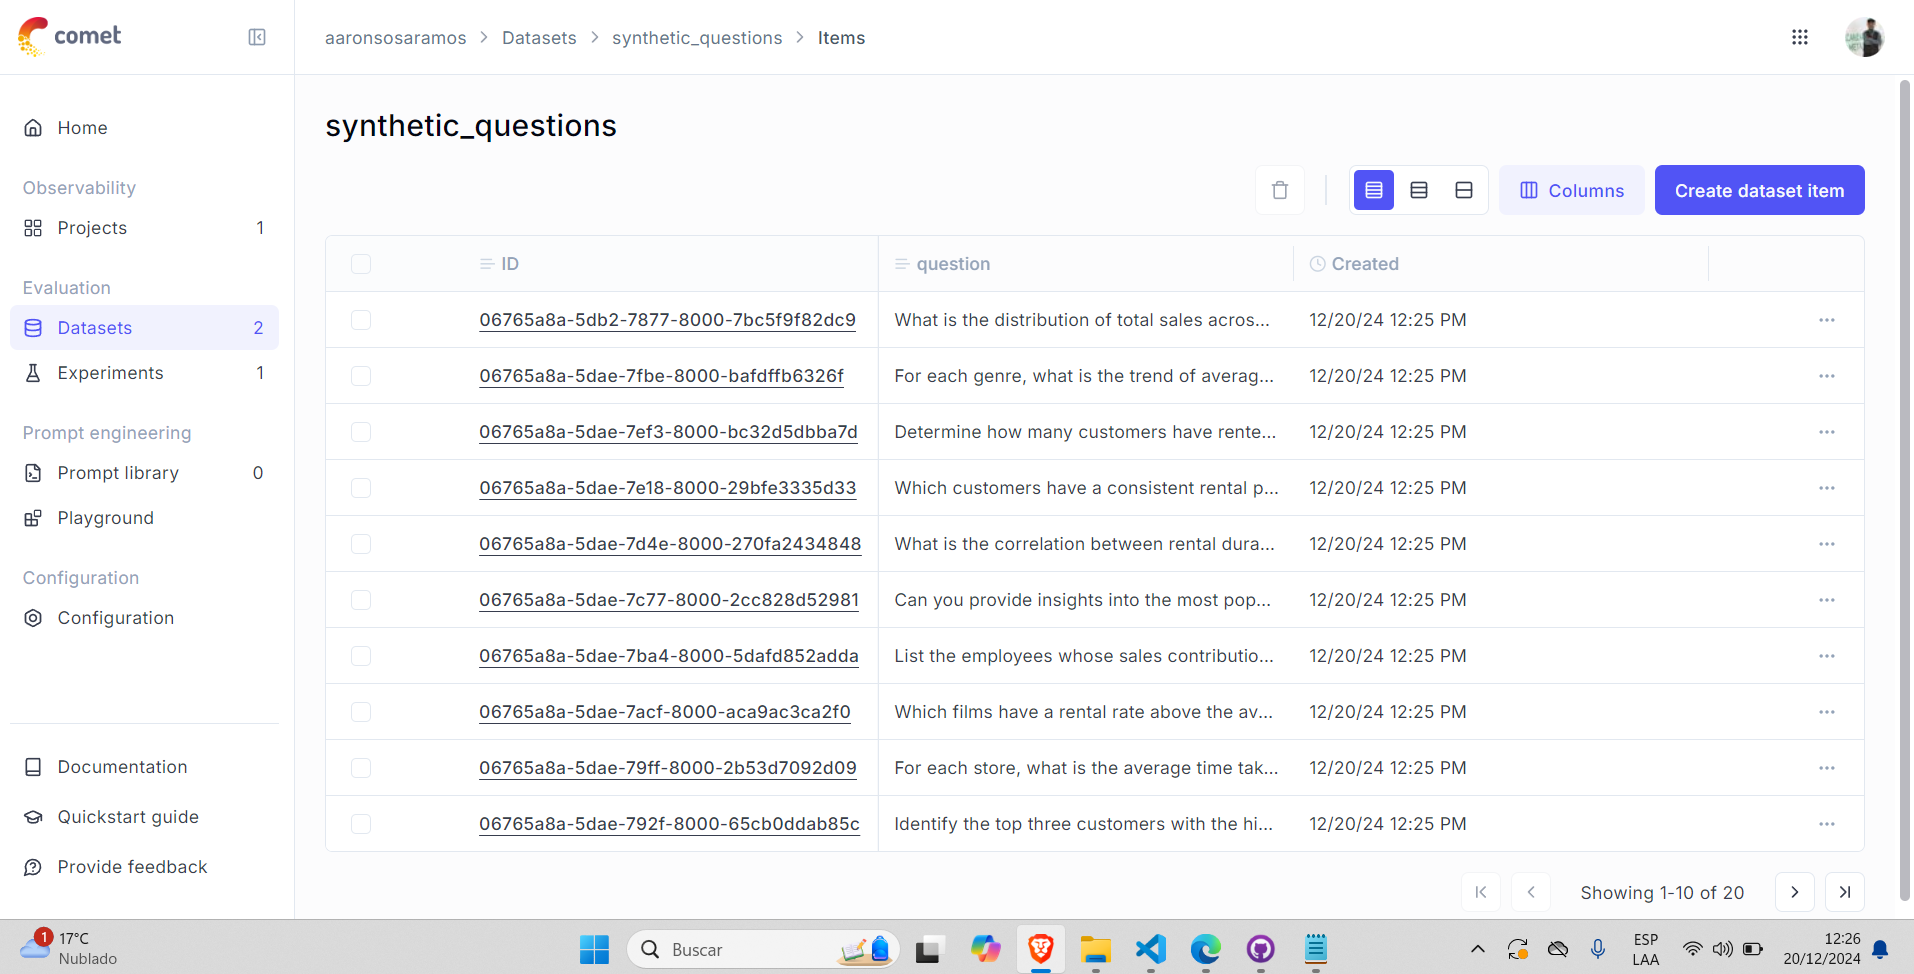

## Creating a LangChain chain

We will be using the `create_sql_query_chain` function from the `langchain` library to create a SQL query to answer the question.

We will be using the `OpikTracer` class from the `opik` library to ensure that the LangChan trace are being tracked in Comet.

In [23]:
# Use langchain to create a SQL query to answer the question
from langchain.chains import create_sql_query_chain
from langchain_openai import ChatOpenAI
from opik.integrations.langchain import OpikTracer

opik_tracer = OpikTracer(tags=["simple_chain"])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
chain = create_sql_query_chain(llm, db).with_config({"callbacks": [opik_tracer]})
response = chain.invoke({"question": "How many employees are there ?"})
response

print(response)

OPIK: Started logging traces to the "Demo Project" project at https://www.comet.com/opik/aaronsosaramos/redirect/projects?name=Demo%20Project.


SQLQuery: `SELECT COUNT("EmployeeId") AS "EmployeeCount" FROM "Employee";`


## Automating the evaluation

In order to ensure our LLM application is working correctly, we will test it on our synthetic dataset.

For this we will be using the `evaluate` function from the `opik` library. We will evaluate the application using a custom metric that checks if the SQL query is valid.

In [24]:
from opik import Opik, track
from opik.evaluation import evaluate
from opik.evaluation.metrics import base_metric, score_result
from typing import Any


class ValidSQLQuery(base_metric.BaseMetric):
    def __init__(self, name: str, db: Any):
        self.name = name
        self.db = db

    def score(self, output: str, **ignored_kwargs: Any):
        # Add you logic here

        try:
            db.run(output)
            return score_result.ScoreResult(
                name=self.name, value=1, reason="Query ran successfully"
            )
        except Exception as e:
            return score_result.ScoreResult(name=self.name, value=0, reason=str(e))


valid_sql_query = ValidSQLQuery(name="valid_sql_query", db=db)

client = Opik()
dataset = client.get_dataset("synthetic_questions")


@track()
def llm_chain(input: str) -> str:
    response = chain.invoke({"question": input})

    return response


def evaluation_task(item):
    response = llm_chain(item["question"])

    return {"output": response}


res = evaluate(
    experiment_name="SQL question answering",
    dataset=dataset,
    task=evaluation_task,
    scoring_metrics=[valid_sql_query],
    nb_samples=20,
)

Evaluation: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


╭─ synthetic_questions (20 samples) ─╮
│                                    │
│ Total time:        00:00:05        │
│ Number of samples: 20              │
│                                    │
│ valid_sql_query: 0.0000 (avg)      │
│                                    │
╰────────────────────────────────────╯

Uploading results to Opik ...

View the results ]8;id=27012;https://www.comet.com/opik/aaronsosaramos/experiments/0193e51a-c7be-7c6f-9cba-e156bd86b62a/compare?experiments=%5B%2206765ab9-eb0b-711b-8000-f109c800215e%22%5D\in your Opik dashboard]8;;\.

The evaluation results are now uploaded to the Opik platform and can be viewed in the UI.

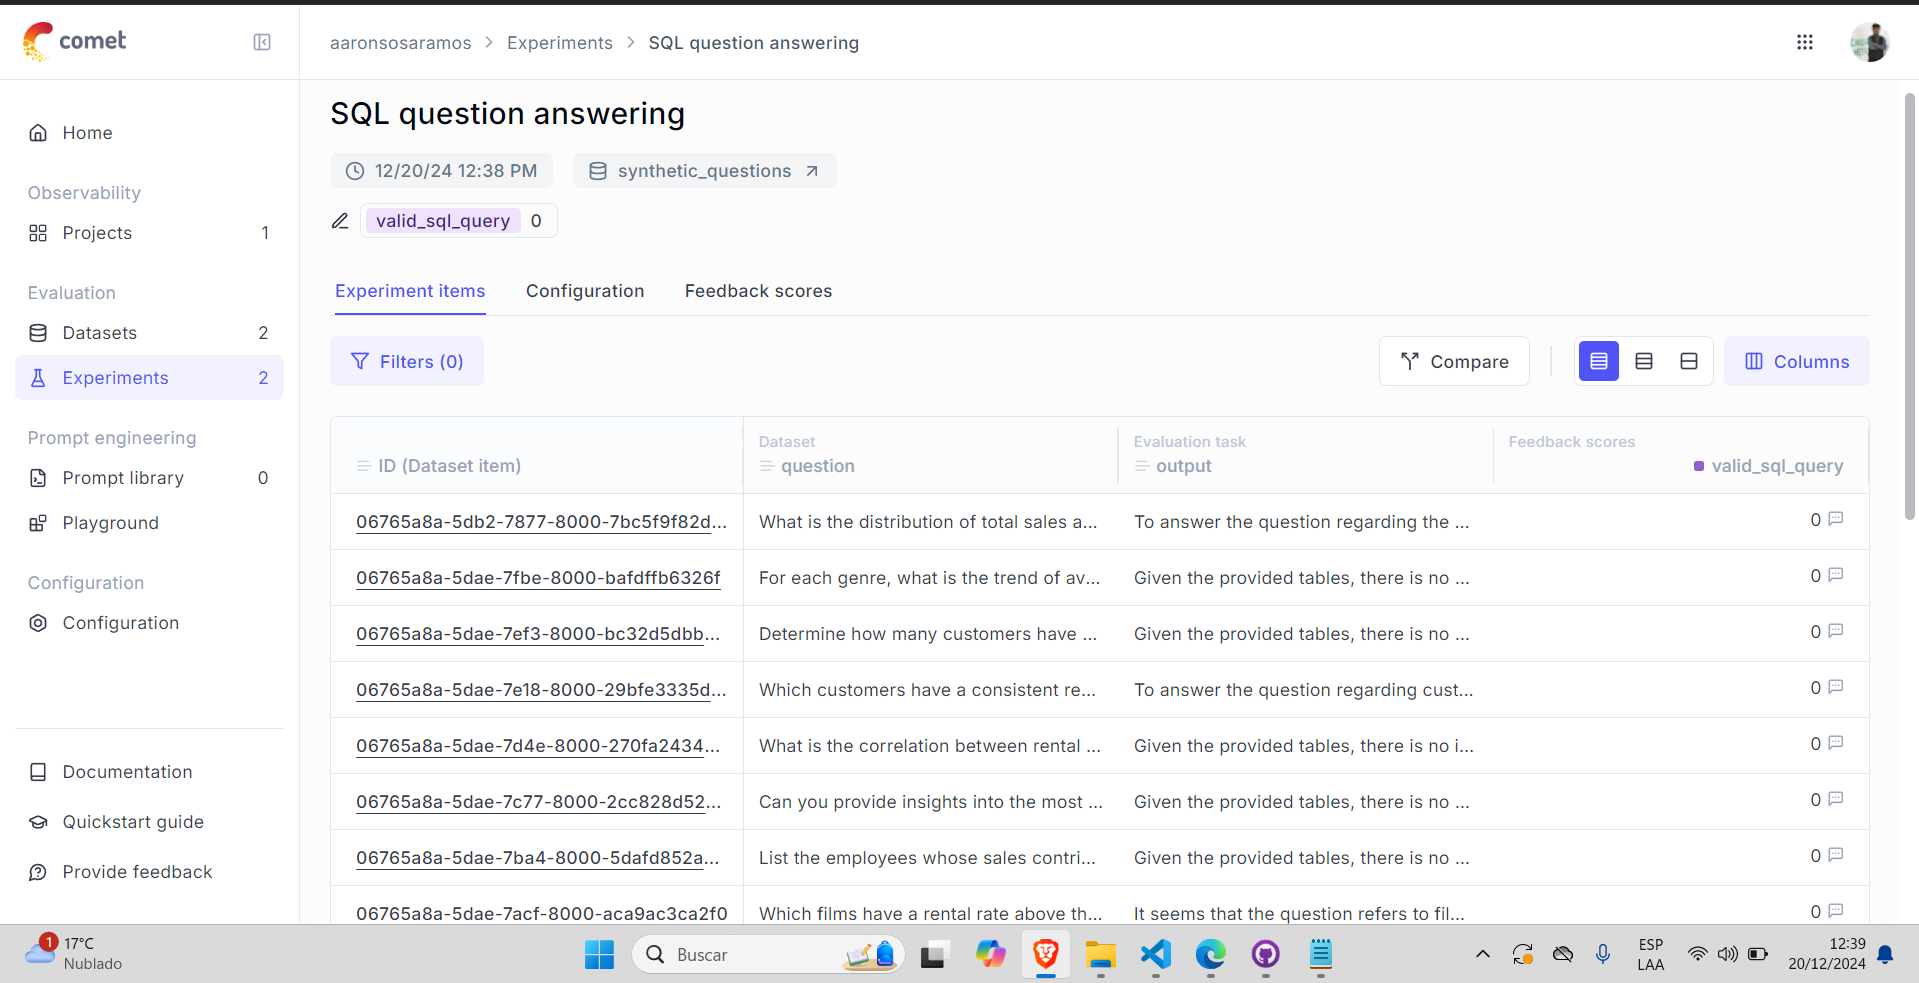